In [5]:
import numpy as np
from pathlib import Path
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, img_to_array, load_img

import matplotlib.pyplot as plt

In [2]:
#ln -s /Users/giakhang/Downloads/dataset_catdog ./

In [3]:
BASE_PATH = "dataset_catdog"
TRAIN_PATH = 'train'
VALID_PATH = 'valid'
TEST_PATH = 'test'
CLASSES = ['cat', 'dog']
IMG_PATH1= Path.cwd() / BASE_PATH / TEST_PATH / 'cat/cat.4001.jpg'
IMG_PATH2 = Path.cwd() / BASE_PATH / TEST_PATH / 'dog/dog.4001.jpg'
IMG_SIZE = (224,224)

1/1 [==============================] - 0s 256ms/step


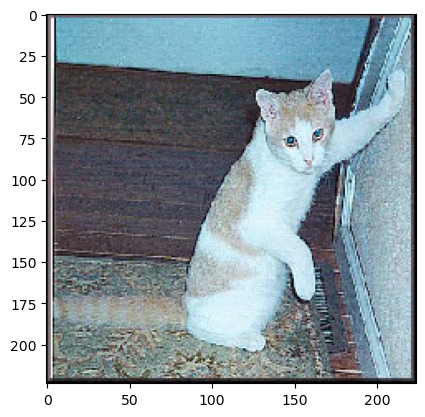

In [4]:
# Bước 1. Load model VGG16
model = VGG16(weights='imagenet', include_top=True)

# Bước 2. Load ảnh + Tiền xử lý ảnh
# 2.1 Load ảnh
img = load_img(IMG_PATH1, color_mode='rgb', target_size=IMG_SIZE)

# 2.2 Tiền xử lý ảnh
x = img_to_array(img) # chuyển ảnh về numpy
x = preprocess_input(x) # tiền xử lý ảnh
x = np.expand_dims(x, 0) # thêm chiều batch

# 2.3 Gọi hàm predict
predictions = model.predict(x)

# 2.4 Lấy thông tin dự đoán (class, description, probability)
decodes = decode_predictions(predictions, top=3)

# 2.5 Xuất tên lớp
plt.imshow(img)



In [5]:
decodes

[[('n02124075', 'Egyptian_cat', 0.5332914),
  ('n02441942', 'weasel', 0.35218403),
  ('n02123045', 'tabby', 0.019341659)]]

In [6]:
import os
import numpy as np
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory

BASE_PATH = "dataset_catdog"
TRAIN_PATH = 'train'
VALID_PATH = 'valid'
TEST_PATH = 'test'
CLASSES = ['cat', 'dog']

train_dataset = image_dataset_from_directory(Path.cwd() / BASE_PATH / TRAIN_PATH ,
                                             image_size=(224, 224),
                                             batch_size=32,
                                             label_mode='categorical',
                                             class_names=CLASSES,
                                             color_mode='rgb',
                                             shuffle=True,
                                             seed=12)

validation_dataset = image_dataset_from_directory(Path.cwd() / BASE_PATH / VALID_PATH ,
                                                  image_size=(224, 224),
                                                  batch_size=32,
                                                  label_mode='categorical',
                                                  class_names=CLASSES,
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  seed=12)
test_dataset = image_dataset_from_directory(Path.cwd() / BASE_PATH / TEST_PATH ,
                                            image_size=(224, 224),
                                            batch_size=32,
                                            label_mode='categorical',
                                            class_names=CLASSES,
                                            color_mode='rgb')

for images_batch, labels_batch in train_dataset:
    print("images batch shape:", images_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 7005 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.
images batch shape: (32, 224, 224, 3)
labels batch shape: (32, 2)


In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.models import Model

def CNN_Cat_Dog():
    inputs = Input(shape=(224, 224, 3))
    x = Rescaling(1.0/255)(inputs)

    x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Flatten()(x)

    x = Dense(128, activation='relu')(x)

    outputs = Dense(units=2, activation='softmax')(x)
    model = Model(inputs = inputs, outputs=outputs)
    
    return model

In [8]:
from keras.callbacks import ModelCheckpoint

# Tạo model
model = CNN_Cat_Dog()
model.summary()

# Compile mô hình
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [ModelCheckpoint(filepath="convnet_from_scratch.keras",
             save_best_only=True, monitor="val_loss")]
# train mô hình
history = model.fit(train_dataset, epochs=5,
                    validation_data=validation_dataset, 
                    callbacks=callbacks)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                        

KeyboardInterrupt: 

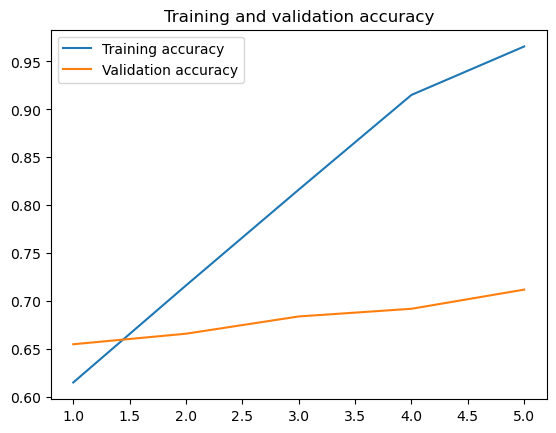

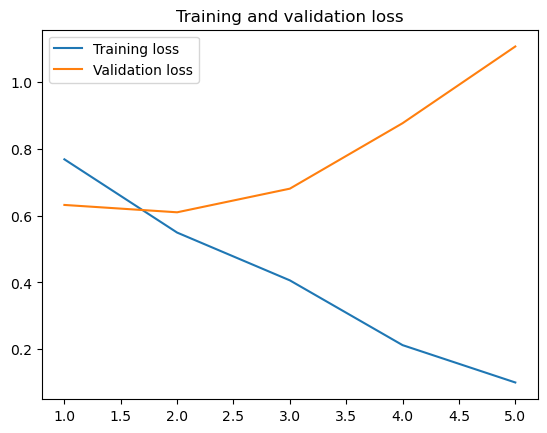

In [17]:
# Vẽ biểu đồ huấn luyện
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
from keras.models import load_model

# Kiểm tra mô hình
test_model = load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

64/64 [==============================] - 6s 92ms/step - loss: 0.6324 - accuracy: 0.6609
Test accuracy: 0.661


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential ([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)])

In [10]:
def VGG_FeatureExtraction():
    # Tầng sinh dữ liệu
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)])
    
    # Load mô hình VGG16
    conv_base = VGG16(weights='imagenet', include_top=False)
    #conv_base.summary()
    
    # Đóng băng các tầng conv
    freeze_until_layer = 'block4_conv3'
    for layer in conv_base.layers:
        #if layer.name == freeze_until_layer:
            #break
        layer.trainable = False


    inputs = Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    
    x = conv_base(x)
    
    # Thêm tầng Dense các tầng denses và dropout(0.5)
    x = Flatten()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(units=2, activation='softmax')(x)
    model = Model(inputs = inputs, outputs=outputs)
    
    return model

In [11]:
model = VGG_FeatureExtraction()

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [ ]:
# Compile mô hình
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks = [ModelCheckpoint(filepath="convnet_from_scratch.keras",
             save_best_only=True, monitor="val_loss")]
# train mô hình
history = model.fit(train_dataset, epochs=5,
                    validation_data=validation_dataset, 
                    callbacks=callbacks)

Epoch 1/5
